# Transforming Continuous Values to Discrete Events

The role of the trigger function in the conviction voting algorithm is to determine if a sufficient amount of conviction has accumulated in support of a particular proposal. In the 1hive use case for conviction, proposals map to precise quantities of resources $r$ requested from a communal resource pool $R$ (which is time varying $R_t$ but we will drop the subscript for ease of reading). Further more there is a supply of governance tokens $S$ which are being used as part of the goverance process.  In the implementation the quantity $S$ will be the effective supply which is the subset of the total Supply for the governance token in question. We assume a time varying supply $S_t$ and thereforewe can interpret $S_t$ as the effective supply without loss of generality. Furthermore we drop the subscript and refer to $S$ for ease of reading. The process of passing a proposal results in an allocation of $r$ funds as shown in the figure below.

![](images/stockflow_cv_trigger.png)

The trigger function is characterized by a set of parameters in addition to the current state of the system: $R$ and $S$. Those parameters are $\alpha$, $\beta$ and $\rho$.

$\alpha \in (0,1)$ is the conviction rate parameter defined in [LINK TO Deriving Alpha] and should be tuned according to a desired half life.

$\beta\in (0,1)$ is the assymptotic limit for trigger function. It is impossible to discharge more $\beta$ share of funds. 

$\rho \in (0, \beta^2)$ is a the scale factor for trigger function. Note that we require $0<\rho <\beta^2$  

The trigger function:

$y^*(r) = y^*(r) = \frac{\rho S}{(1-\alpha)\left(\beta^2 - \frac{r}{R}\right) }$

The geometric properties of this function with respect to the parameter choices are shown here:

![](images/trigger_geometry.png)

Note that by requiring that: $0<\rho <\beta^2$ the following holds $0<\frac{\rho}{\beta^2}<1$ and $0<\beta - \sqrt \rho <\beta <1$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from cadCAD.configuration.utils import config_sim
from model.parts.utils import *
from model.parts.sys_params import * 

Pull params out of the existing files or use this notebook to ovewrite them with your own choices to see how the plots are affected.

In [4]:
initial_values

{'initial_sentiment': 0.6,
 'n': 30,
 'm': 7,
 'initial_funds': 4867.21,
 'supply': 22392.22}

In [73]:
params

{'beta': [0.2],
 'rho': [0.0025],
 'alpha': [0.7937005259840998],
 'gamma': [0.001],
 'sensitivity': [0.75],
 'tmin': [1],
 'min_supp': [1],
 'base_completion_rate': [45],
 'base_failure_rate': [180],
 'base_engagement_rate': [0.3],
 'lowest_affinity_to_support': [0.3]}

In [8]:
supply = initial_values['supply']
funds = initial_values['initial_funds']

alpha = params['alpha'][0]
beta = params['beta'][0]
rho = params['rho'][0]


In [9]:
def trigger(requested, funds, supply, alpha, beta, rho):
    '''
    Function that determines threshold for proposals being accepted.
    Refactored slightly from built in to be explicit for demo
    '''
    share = requested/funds
    if share < beta:
        threshold = rho*supply/(beta-share)**2  * 1/(1-alpha)
        return threshold 
    else: 
        return np.inf

## Simple derivations:

min_required_conviction = $y^*(0) = \frac{\rho S}{(1-\alpha)\beta^2}$

max_achievable_conviction = $\frac{S}{1-\alpha}$

min_required_conviction_as_a_share_of_max = $\frac{\rho S}{(1-\alpha)\beta^2} \cdot \frac{1-\alpha}{S} = \frac{\rho}{\beta^2}$

To compute the max_achievable_request solve: 

$\frac{S}{1-\alpha} = \frac{\rho S}{(1-\alpha)\left(\beta-\frac{r}{R}\right)^2}$

max_achievable_request = $r = (\beta -\sqrt\rho)F$

In [72]:
min_required_conviction = trigger(0, funds, supply, alpha, beta, rho)
print("min_required_conviction ="+str(min_required_conviction))

max_achievable_conviction = supply/(1-alpha)
print("max_achievable_conviction ="+str(max_achievable_conviction))
print("")
print("min_achievable_conviction_as_a_share_of_max_achievable_conviction ="+str(min_required_conviction/max_achievable_conviction))
print("")
max_request = beta*funds
max_achievable_request = (beta - np.sqrt(rho))*funds
print("max_achievable_request ="+str(max_achievable_request))
print("total_funds ="+str(funds))
print("")
print("max_achievable_request_as_a_share_of_funds ="+str(max_achievable_request/funds))

granularity = 100 

requests = np.arange(0,.9*max_request, max_request/granularity)
requests_as_share_of_funds = requests/funds
conviction_required = np.array([trigger(r, funds, supply, alpha, beta, rho) for r in requests])
conviction_required_as_share_of_max = conviction_required/max_achievable_conviction


min_required_conviction =6783.893932236272
max_achievable_conviction =108542.30291578037

min_achievable_conviction_as_a_share_of_max_achievable_conviction =0.06249999999999999

max_achievable_request =730.0815000000001
total_funds =4867.21

max_achievable_request_as_a_share_of_funds =0.15000000000000002


First set of plots in "Absolute Terms" based on alpha, Supply and Funds as above

Text(0, 0.5, 'Conviction Required to Pass')

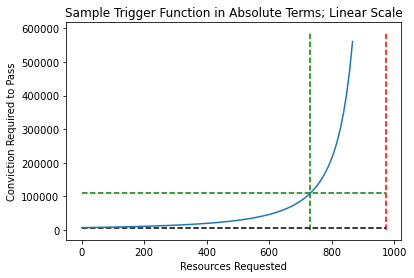

In [32]:
plt.plot(requests, conviction_required)
ax= plt.gca().axis()
plt.vlines(max_request, 0, ax[3], 'r', '--')
plt.vlines(max_achievable_request, 0, ax[3], 'g', '--')
plt.hlines(max_achievable_conviction, 0, max_request, 'g', '--')
plt.hlines(min_required_conviction, 0, max_request, 'k', '--')
plt.title("Sample Trigger Function in Absolute Terms; Linear Scale")
plt.xlabel("Resources Requested")
plt.ylabel("Conviction Required to Pass")

(0.0, 119396.53320735841)

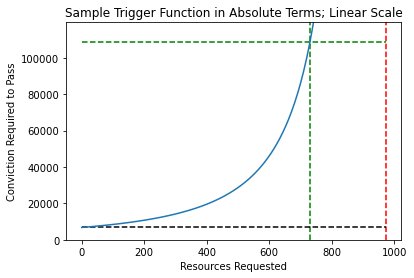

In [55]:
#ZOOM IN
plt.plot(requests, conviction_required)
ax= plt.gca().axis()
plt.vlines(max_request, 0, ax[3], 'r', '--')
plt.vlines(max_achievable_request, 0, ax[3], 'g', '--')
plt.hlines(max_achievable_conviction, 0, max_request, 'g', '--')
plt.hlines(min_required_conviction, 0, max_request, 'k', '--')
plt.title("Sample Trigger Function in Absolute Terms; Linear Scale")
plt.xlabel("Resources Requested")
plt.ylabel("Conviction Required to Pass")
plt.gca().set_ylim(0, max_achievable_conviction*(1.1))

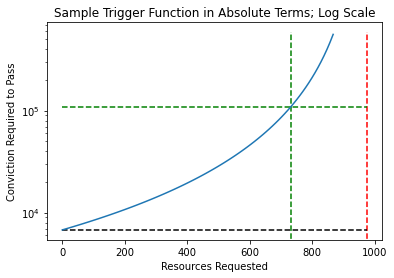

In [54]:
plt.plot(requests, conviction_required)
ax= plt.gca().axis()
plt.vlines(max_request, 0, ax[3], 'r', '--')
plt.vlines(max_achievable_request, 0, ax[3], 'g', '--')
plt.hlines(max_achievable_conviction, 0, max_request, 'g', '--')
plt.hlines(min_required_conviction, 0, max_request, 'k', '--')
plt.title("Sample Trigger Function in Absolute Terms; Log Scale")
plt.xlabel("Resources Requested")
plt.ylabel("Conviction Required to Pass")
plt.gca().set_yscale('log')

(3391.946966118136, 217084.60583156074)

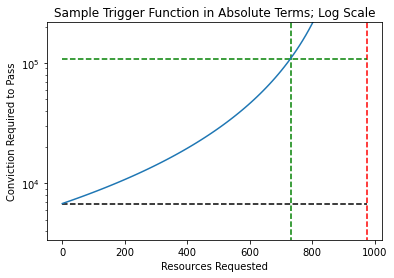

In [61]:
#Zoom in
plt.plot(requests, conviction_required)
ax= plt.gca().axis()
plt.vlines(max_request, 0, ax[3], 'r', '--')
plt.vlines(max_achievable_request, 0, ax[3], 'g', '--')
plt.hlines(max_achievable_conviction, 0, max_request, 'g', '--')
plt.hlines(min_required_conviction, 0, max_request, 'k', '--')
plt.title("Sample Trigger Function in Absolute Terms; Log Scale")
plt.xlabel("Resources Requested")
plt.ylabel("Conviction Required to Pass")
plt.gca().set_yscale('log')
plt.gca().set_ylim(min_required_conviction/2, max_achievable_conviction*2)

Second set of plots in "Relative Terms" which knock out the dependence on alpha and supply, as well as treating requests as share of total funds.

Text(0, 0.5, 'Conviction Required to Pass as share of max achievable')

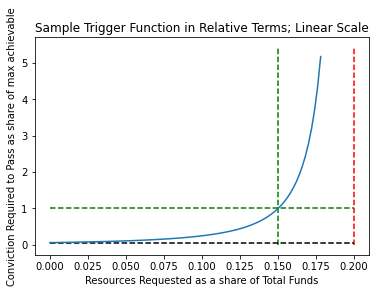

In [62]:
plt.plot(requests_as_share_of_funds, conviction_required_as_share_of_max)
ax= plt.gca().axis()
plt.vlines(max_request/funds, 0, ax[3], 'r', '--')
plt.vlines(max_achievable_request/funds, 0, ax[3], 'g', '--')
plt.hlines(1, 0, max_request/funds, 'g', '--')
plt.hlines(min_required_conviction/max_achievable_conviction, 0, max_request/funds, 'k', '--')
plt.title("Sample Trigger Function in Relative Terms; Linear Scale")
plt.xlabel("Resources Requested as a share of Total Funds")
plt.ylabel("Conviction Required to Pass as share of max achievable")

(0.0, 1.1)

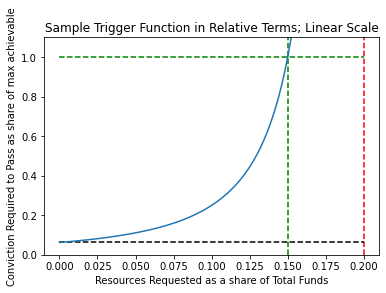

In [63]:
#zoom in
plt.plot(requests_as_share_of_funds, conviction_required_as_share_of_max)
ax= plt.gca().axis()
plt.vlines(max_request/funds, 0, ax[3], 'r', '--')
plt.vlines(max_achievable_request/funds, 0, ax[3], 'g', '--')
plt.hlines(1, 0, max_request/funds, 'g', '--')
plt.hlines(min_required_conviction/max_achievable_conviction, 0, max_request/funds, 'k', '--')
plt.title("Sample Trigger Function in Relative Terms; Linear Scale")
plt.xlabel("Resources Requested as a share of Total Funds")
plt.ylabel("Conviction Required to Pass as share of max achievable")
plt.gca().set_ylim(0, 1.1)

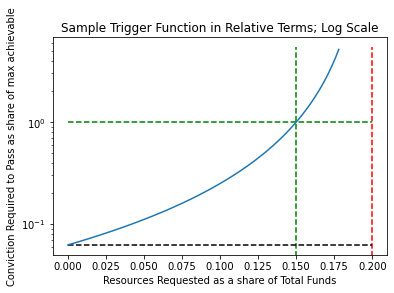

In [66]:
plt.plot(requests_as_share_of_funds, conviction_required_as_share_of_max)
ax= plt.gca().axis()
plt.vlines(max_request/funds, 0, ax[3], 'r', '--')
plt.vlines(max_achievable_request/funds, 0, ax[3], 'g', '--')
plt.hlines(1, 0, max_request/funds, 'g', '--')
plt.hlines(min_required_conviction/max_achievable_conviction, 0, max_request/funds, 'k', '--')
plt.title("Sample Trigger Function in Relative Terms; Log Scale")
plt.xlabel("Resources Requested as a share of Total Funds")
plt.ylabel("Conviction Required to Pass as share of max achievable")
plt.gca().set_yscale('log')

(0.031249999999999997, 2)

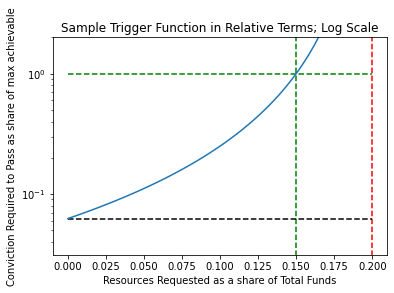

In [68]:
#zoom in
plt.plot(requests_as_share_of_funds, conviction_required_as_share_of_max)
ax= plt.gca().axis()
plt.vlines(max_request/funds, 0, ax[3], 'r', '--')
plt.vlines(max_achievable_request/funds, 0, ax[3], 'g', '--')
plt.hlines(1, 0, max_request/funds, 'g', '--')
plt.hlines(min_required_conviction/max_achievable_conviction, 0, max_request/funds, 'k', '--')
plt.title("Sample Trigger Function in Relative Terms; Log Scale")
plt.xlabel("Resources Requested as a share of Total Funds")
plt.ylabel("Conviction Required to Pass as share of max achievable")
plt.gca().set_yscale('log')
plt.gca().set_ylim(min_required_conviction/max_achievable_conviction/2,2)

Third set of plots are heatmaps to show the simultaneous variation of multiple parameters with a focus on alpha and supply.

In [1]:


sim_config = config_sim({
    'N': 1,
    'T': range(100), #day 
    'M': params,
})

In [2]:
supply = initial_values['supply']
alpha = sim_config[0]['M']['alpha']

mcv = supply/(1-alpha)
print('for reference: max conviction = '+str(np.log10(mcv))+'in log10 units')

for reference: max conviction = 5.035599031662158in log10 units


In [3]:
supply_sweep = trigger_sweep('effective_supply',trigger_threshold, sim_config[0]['M'], supply)
alpha_sweep = trigger_sweep('alpha',trigger_threshold, sim_config[0]['M'], supply)

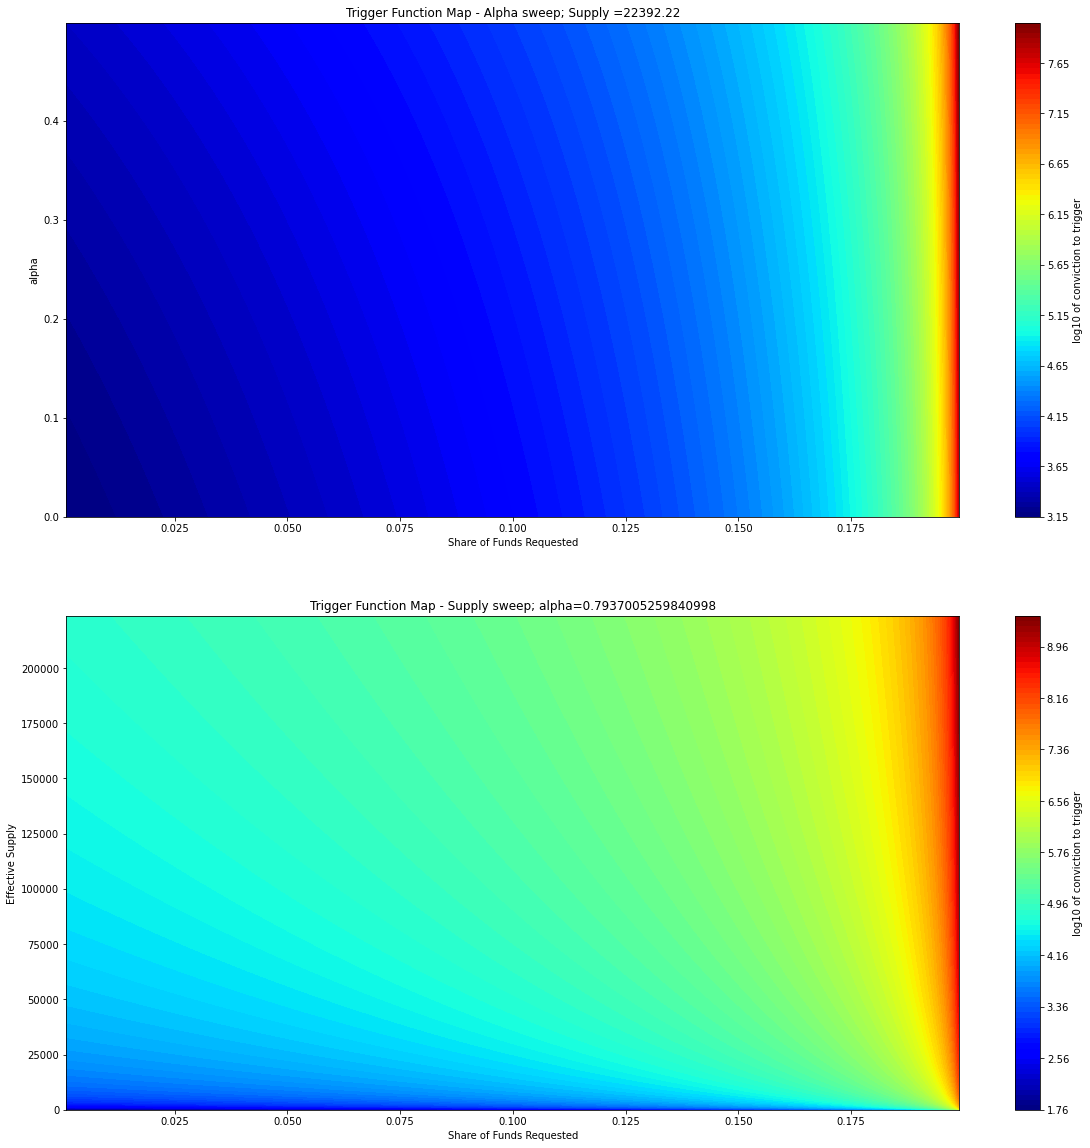

In [4]:
trigger_grid(supply_sweep, alpha_sweep)

These plots demonstrate the increasing conviction required to pass a proposal when either % of funds requested, effective supply, or alpha parameter is high. Blue areas represent lower required conviction, and red areas represent impossibly high conviction. This ensures that the reserve pool of funds are not depleted by a small number of large proposals.
